In [20]:
from datasets import load_dataset
import torch
import numpy as np
from tqdm.auto import tqdm

In [2]:
dataset = load_dataset("AIHowto/Chilloutmix_woman_regset1", split="train")

In [3]:
from torchvision import transforms

In [4]:
image_size = 64

In [5]:
preprocess = transforms.Compose(
    [
        transforms.Lambda(lambda img: img.convert("RGB")),
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [6]:
def transform(examples):
    examples = [preprocess(image) for image in examples["image"]]
    return {"images": examples}

In [7]:
dataset.set_transform(transform)

In [8]:
batch_size = 16
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

In [9]:
batch = next(iter(train_dataloader))

In [10]:
import matplotlib.pyplot as plt
def show_batch(batch, batch_size=8, nrows=2):
    ncols = batch_size // nrows
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
    axes = axes.flatten()

    for j in range(batch_size):
        img = batch[j]
        img = (img / 2 + 0.5).clamp(0, 1)
        img = img.detach().cpu().permute(1, 2, 0).numpy()
        
        axes[j].imshow(img)
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

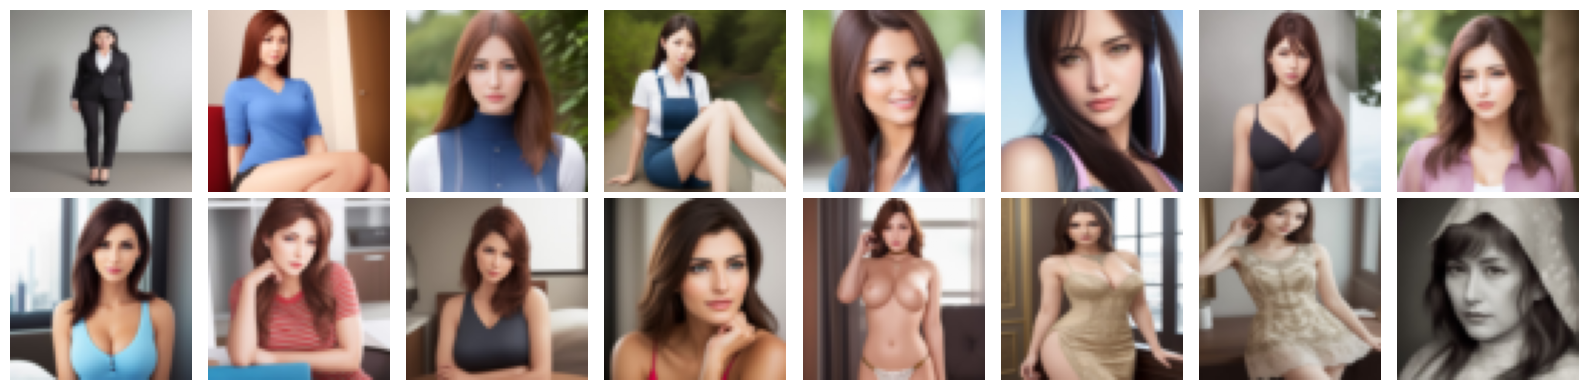

In [11]:
show_batch(batch["images"], batch_size=batch_size, nrows=2)

In [12]:
from diffusers import DDPMScheduler
from diffusers import DDPMPipeline
scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02
)

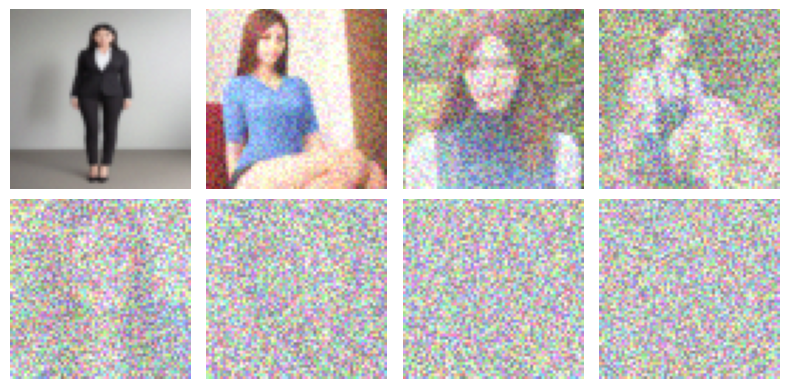

In [13]:
timesteps = torch.linspace(0, 999, 8).long()
x = batch["images"][:8]
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)
show_batch(noised_x, batch_size=8)

In [14]:
from diffusers import UNet2DModel
device = "cuda" if torch.cuda.is_available() else "cpu"

In [33]:
model = UNet2DModel(
    in_channels=3,
    sample_size=image_size,
    block_out_channels=(64, 128, 256, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
).to(device)

"DownBlock2D": convolution + downsample (stride=2)

"AttnDownBlock2D": convolution + attention layer + downsample

Ở đây, encoder có 2 block thường + 2 block attention → cho phép U-Net capture long-range dependencies (rất quan trọng trong diffusion model).

In [16]:
with torch.inference_mode():
    out = model(noised_x.to(device), timestep=timesteps.to(device)).sample
print(noised_x.shape, out.shape)

torch.Size([8, 3, 64, 64]) torch.Size([8, 3, 64, 64])


In [17]:
from torch.nn import functional as F

In [18]:
num_epochs = 90
lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
losses = []

In [19]:
for epoch in range(num_epochs):
    epoch_bar = tqdm(train_dataloader, 
                     desc=f"Epoch {epoch+1}/{num_epochs}",
                     leave=True)
    
    epoch_losses = []
    
    for batch in epoch_bar:
        clean_images = batch["images"].to(device)
        noise = torch.randn(clean_images.shape).to(device)
        
        timesteps = torch.randint(
            0, 
            scheduler.config.num_train_timesteps, 
            (clean_images.shape[0],),
            device=device
        ).long()
        
        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
        
        loss = F.mse_loss(noise_pred, noise)
        epoch_losses.append(loss.item())
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Cập nhật progress bar với loss hiện tại
        epoch_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'avg_loss': f'{sum(epoch_losses)/len(epoch_losses):.4f}'
        })
    
    # In loss trung bình của epoch
    avg_loss = sum(epoch_losses) / len(epoch_losses)
    print(f"Epoch {epoch+1} completed - Average Loss: {avg_loss:.4f}")

Epoch 1/10:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 1 completed - Average Loss: 0.1240


Epoch 2/10:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 2 completed - Average Loss: 0.0363


Epoch 3/10:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 3 completed - Average Loss: 0.0263


Epoch 4/10:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 4 completed - Average Loss: 0.0230


Epoch 5/10:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 5 completed - Average Loss: 0.0206


Epoch 6/10:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 6 completed - Average Loss: 0.0195


Epoch 7/10:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 7 completed - Average Loss: 0.0188


Epoch 8/10:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 8 completed - Average Loss: 0.0175


Epoch 9/10:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 9 completed - Average Loss: 0.0166


Epoch 10/10:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 10 completed - Average Loss: 0.0149


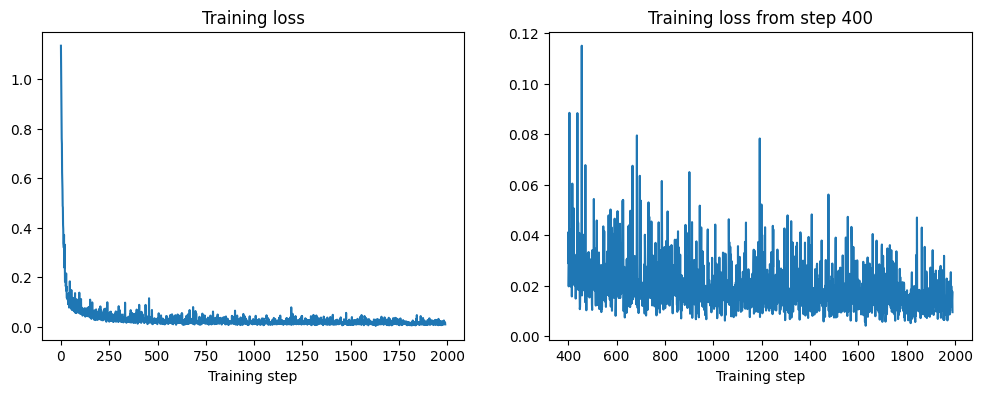

In [20]:
from matplotlib import pyplot as plt
plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Training loss")
plt.xlabel("Training step")
plt.subplot(1, 2, 2)
plt.plot(range(400, len(losses)), losses[400:])
plt.title("Training loss from step 400")
plt.xlabel("Training step");

In [25]:
checkpoint_path = "women_unet_epoch90.pth"
torch.save({
    'epoch': 90,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_loss,
}, checkpoint_path)

In [36]:
checkpoint = torch.load("women_unet_epoch90.pth", map_location=device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

start_epoch = checkpoint['epoch']

print(f"Resume training from epoch {start_epoch+1}")

num_epochs = 30

for epoch in range(start_epoch, start_epoch + num_epochs):
    epoch_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}", leave=True)
    epoch_losses = []

    for batch in epoch_bar:
        clean_images = batch["images"].to(device)
        noise = torch.randn(clean_images.shape).to(device)
        timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (clean_images.shape[0],), device=device).long()

        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        loss = F.mse_loss(noise_pred, noise)
        epoch_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss = sum(epoch_losses) / len(epoch_losses)

        epoch_bar.set_postfix({'loss': f'{loss.item():.4f}', 'avg_loss': f'{avg_loss:.4f}'})
    
    print(f"Epoch {epoch+1} completed - Average Loss: {sum(epoch_losses)/len(epoch_losses):.4f}")

Resume training from epoch 91


Epoch 91:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 91 completed - Average Loss: 0.0112


Epoch 92:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 92 completed - Average Loss: 0.0115


Epoch 93:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 93 completed - Average Loss: 0.0113


Epoch 94:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 94 completed - Average Loss: 0.0111


Epoch 95:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 95 completed - Average Loss: 0.0116


Epoch 96:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 96 completed - Average Loss: 0.0112


Epoch 97:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 97 completed - Average Loss: 0.0111


Epoch 98:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 98 completed - Average Loss: 0.0114


Epoch 99:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 99 completed - Average Loss: 0.0117


Epoch 100:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 100 completed - Average Loss: 0.0112


Epoch 101:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 101 completed - Average Loss: 0.0111


Epoch 102:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 102 completed - Average Loss: 0.0112


Epoch 103:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 103 completed - Average Loss: 0.0108


Epoch 104:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 104 completed - Average Loss: 0.0113


Epoch 105:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 105 completed - Average Loss: 0.0109


Epoch 106:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 106 completed - Average Loss: 0.0109


Epoch 107:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 107 completed - Average Loss: 0.0112


Epoch 108:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 108 completed - Average Loss: 0.0110


Epoch 109:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 109 completed - Average Loss: 0.0111


Epoch 110:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 110 completed - Average Loss: 0.0105


Epoch 111:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 111 completed - Average Loss: 0.0112


Epoch 112:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 112 completed - Average Loss: 0.0114


Epoch 113:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 113 completed - Average Loss: 0.0107


Epoch 114:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 114 completed - Average Loss: 0.0111


Epoch 115:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 115 completed - Average Loss: 0.0105


Epoch 116:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 116 completed - Average Loss: 0.0118


Epoch 117:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 117 completed - Average Loss: 0.0118


Epoch 118:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 118 completed - Average Loss: 0.0105


Epoch 119:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 119 completed - Average Loss: 0.0114


Epoch 120:   0%|          | 0/199 [00:00<?, ?it/s]

Epoch 120 completed - Average Loss: 0.0107


In [37]:
checkpoint_path = "women_unet_epoch120.pth"
torch.save({
    'epoch': 120,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_loss,
}, checkpoint_path)

  0%|          | 0/1000 [00:00<?, ?it/s]

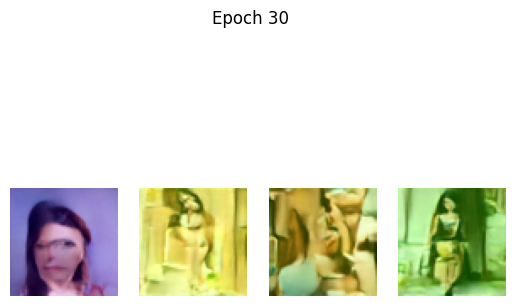

  0%|          | 0/1000 [00:00<?, ?it/s]

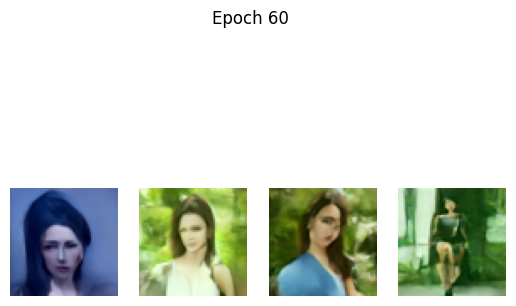

  0%|          | 0/1000 [00:00<?, ?it/s]

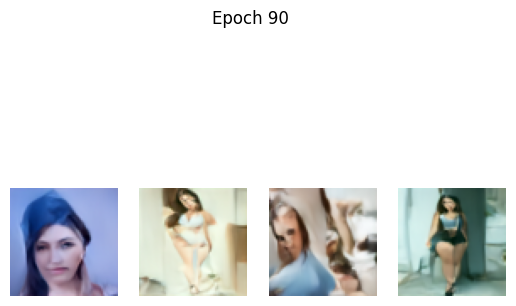

  0%|          | 0/1000 [00:00<?, ?it/s]

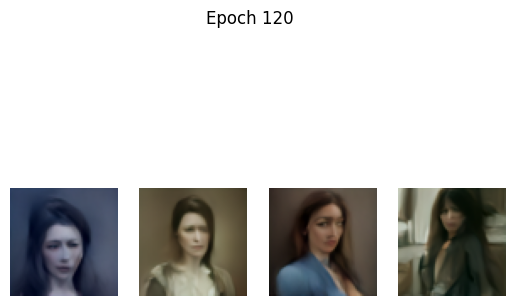

In [40]:
for epoch in [30, 60, 90, 120]:
    # load checkpoint .pth
    checkpoint_path = f"women_unet_epoch{epoch}.pth"
    checkpoint = torch.load(checkpoint_path, map_location=device)
    # nạp trọng số từ checkpoint
    model.load_state_dict(checkpoint["model_state_dict"])

    # tạo pipeline
    pipeline = DDPMPipeline(unet=model, scheduler=scheduler).to(device)

    # sinh ảnh với noise cố định
    generator = torch.manual_seed(731280283)
    ims = pipeline(batch_size=4, generator=generator).images

    # ví dụ hiển thị
    import matplotlib.pyplot as plt
    for i, im in enumerate(ims):
        plt.subplot(1, 4, i+1)
        plt.imshow(im)
        plt.axis("off")
    plt.suptitle(f"Epoch {epoch}")
    plt.show()